In [1]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os

In [2]:
degree = 5
n_nodes = 100
rate = 0.5
T = 100
dt = 0.01
fprefix = 'testdata/rrg_sis_'
train_sample = 10000
val_sample = 1000

def conversion_function(x):
    ans = [None] * len(x)
    for i in range(len(x)):
        if x[i] == 'S': ans[i] = 0.
        if x[i] == 'I': ans[i] = 1.
    return torch.tensor(ans)


In [3]:
# Generating the network
if not os.path.exists(fprefix + 'edgelist.b') or not os.path.exists(fprefix + 'states.b'):
    graph = nx.random_regular_graph(degree, n_nodes)
    nx.write_edgelist(graph, fprefix + 'edgelist.b')
    
    # Generating the time series
    continue_simu = False
    iter_max = 100
    i = 0
    
    

    #if os.path.exists(fprefix + '_states.b'):
    #    os.remove(fprefix + '_states.b')
    data = {}
    idx = 0
    while(i < train_sample):
        data[idx] = []
        sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt, filename=None,
                                        full_data_mode=True, overwrite=True)
        t = 0
        while(t < T and sisnet.continue_simu and i < train_sample):
            t += dt
            sisnet.update(record=False)
            i += 1
            data[idx].append(sisnet.activity)
        idx += 1

    f = open(fprefix + 'states.b', 'wb')
    pickle.dump(data, f)
    f.close()
else:
    graph = nx.read_edgelist(fprefix + 'edgelist.b', nodetype=int)
        

%reset_selective -f data

In [4]:
dataset = dl.Markov_structured_Dataset(fprefix + 'states.b', fprefix + 'edgelist.b', conversion_function)

In [5]:
n_hidden = [16]
n_embedding = 4
optimizer = lambda p: torch.optim.Adam(p, lr=1e-3)
use_cuda = True

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset) - val_sample, val_sample])

markov_cvae = dl.Markov_Node_CVAE(graph, n_hidden, n_embedding, optimizer=optimizer, use_cuda=use_cuda)

In [6]:
markov_cvae

Markov_Node_CVAE(
  (encoders): ModuleDict(
    (0): Fc_CEncoder(
      (encoder): Sequential(
        (0): Linear(in_features=7, out_features=16, bias=True)
        (1): Tanh()
        (2): Dropout(p=0)
      )
      (mu): Linear(in_features=16, out_features=4, bias=True)
      (var): Linear(in_features=16, out_features=4, bias=True)
    )
    (1): Fc_CEncoder(
      (encoder): Sequential(
        (0): Linear(in_features=7, out_features=16, bias=True)
        (1): Tanh()
        (2): Dropout(p=0)
      )
      (mu): Linear(in_features=16, out_features=4, bias=True)
      (var): Linear(in_features=16, out_features=4, bias=True)
    )
    (10): Fc_CEncoder(
      (encoder): Sequential(
        (0): Linear(in_features=7, out_features=16, bias=True)
        (1): Tanh()
        (2): Dropout(p=0)
      )
      (mu): Linear(in_features=16, out_features=4, bias=True)
      (var): Linear(in_features=16, out_features=4, bias=True)
    )
    (11): Fc_CEncoder(
      (encoder): Sequential(
      

In [8]:
markov_cvae.fit(train_dataset, val_dataset, epochs=19, batch_size=128)

Epoch 1 - Training Loss: 2.5138 ± 0.50 - Validation Loss: 2.5271 ± 0.49 - Training time: 44.4602 - New best config.
Epoch 2 - Training Loss: 2.2002 ± 0.45 - Validation Loss: 2.2128 ± 0.44 - Training time: 44.1682 - New best config.
Epoch 3 - Training Loss: 1.9781 ± 0.41 - Validation Loss: 1.9910 ± 0.41 - Training time: 44.3571 - New best config.
Epoch 4 - Training Loss: 1.8176 ± 0.39 - Validation Loss: 1.8297 ± 0.38 - Training time: 44.1203 - New best config.
Epoch 5 - Training Loss: 1.6974 ± 0.37 - Validation Loss: 1.7077 ± 0.37 - Training time: 44.2275 - New best config.
Epoch 6 - Training Loss: 1.6043 ± 0.36 - Validation Loss: 1.6136 ± 0.35 - Training time: 44.0877 - New best config.
Epoch 7 - Training Loss: 1.5311 ± 0.35 - Validation Loss: 1.5398 ± 0.34 - Training time: 44.0911 - New best config.
Epoch 8 - Training Loss: 1.4697 ± 0.34 - Validation Loss: 1.4775 ± 0.34 - Training time: 43.8376 - New best config.
Epoch 9 - Training Loss: 1.4220 ± 0.35 - Validation Loss: 1.4293 ± 0.34 

In [49]:
def test_model(learned_model, dataset):
    init_states = dataset[0][1]
    T = len(dataset)
    t = 0
    learned_states, z, passed_states = learned_model.predict(init_states)
    learned_avg = [np.mean(list(learned_states.values()))]
    g = learned_model.graph
    while(t < T):
        t += 1
        
        print(t, "/", T)
        learned_states, z, passed_states = learned_model.predict(passed_states)
        learned_states = torch.cat([torch.tensor(learned_states[n][0]) for n in g.node])
        learned_states = torch.bernoulli(torch.tensor(learned_states))
#         print(learned_states, learned_states[list(g.neighbors(0))])
#         print(learned_states, learned_states.size())
        passed_states = {n:torch.cat([learned_states[list(g.neighbors(n))],
                                      learned_states[n].view(1)])
                         for n in g.node}
        learned_avg.append(np.mean(learned_states.numpy()))
    
    return learned_avg

def show_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = list(dataset[i][0].values())
        avg.append(np.mean(x))
    return avg


In [52]:
null_cvae = dl.Markov_Complete_CVAE(n_nodes, n_hidden, n_embedding, optimizer=optimizer, use_cuda=use_cuda)

avg_ts = show_dataset(dataset)
#null_ts = test_model(null_cvae, dataset)
trained_ts = test_model(markov_cvae, dataset)


1 / 9999


/home/charles_murphy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


2 / 9999
3 / 9999
4 / 9999
5 / 9999
6 / 9999
7 / 9999
8 / 9999
9 / 9999
10 / 9999
11 / 9999
12 / 9999
13 / 9999
14 / 9999
15 / 9999
16 / 9999
17 / 9999
18 / 9999
19 / 9999
20 / 9999
21 / 9999
22 / 9999
23 / 9999
24 / 9999
25 / 9999
26 / 9999
27 / 9999
28 / 9999
29 / 9999
30 / 9999
31 / 9999
32 / 9999
33 / 9999
34 / 9999
35 / 9999
36 / 9999
37 / 9999
38 / 9999
39 / 9999
40 / 9999
41 / 9999
42 / 9999
43 / 9999
44 / 9999
45 / 9999
46 / 9999
47 / 9999
48 / 9999
49 / 9999
50 / 9999
51 / 9999
52 / 9999
53 / 9999
54 / 9999
55 / 9999
56 / 9999
57 / 9999
58 / 9999
59 / 9999
60 / 9999
61 / 9999
62 / 9999
63 / 9999
64 / 9999
65 / 9999
66 / 9999
67 / 9999
68 / 9999
69 / 9999
70 / 9999
71 / 9999
72 / 9999
73 / 9999
74 / 9999
75 / 9999
76 / 9999
77 / 9999
78 / 9999
79 / 9999
80 / 9999
81 / 9999
82 / 9999
83 / 9999
84 / 9999
85 / 9999
86 / 9999
87 / 9999
88 / 9999
89 / 9999
90 / 9999
91 / 9999
92 / 9999
93 / 9999
94 / 9999
95 / 9999
96 / 9999
97 / 9999
98 / 9999
99 / 9999
100 / 9999
101 / 9999
102 / 

757 / 9999
758 / 9999
759 / 9999
760 / 9999
761 / 9999
762 / 9999
763 / 9999
764 / 9999
765 / 9999
766 / 9999
767 / 9999
768 / 9999
769 / 9999
770 / 9999
771 / 9999
772 / 9999
773 / 9999
774 / 9999
775 / 9999
776 / 9999
777 / 9999
778 / 9999
779 / 9999
780 / 9999
781 / 9999
782 / 9999
783 / 9999
784 / 9999
785 / 9999
786 / 9999
787 / 9999
788 / 9999
789 / 9999
790 / 9999
791 / 9999
792 / 9999
793 / 9999
794 / 9999
795 / 9999
796 / 9999
797 / 9999
798 / 9999
799 / 9999
800 / 9999
801 / 9999
802 / 9999
803 / 9999
804 / 9999
805 / 9999
806 / 9999
807 / 9999
808 / 9999
809 / 9999
810 / 9999
811 / 9999
812 / 9999
813 / 9999
814 / 9999
815 / 9999
816 / 9999
817 / 9999
818 / 9999
819 / 9999
820 / 9999
821 / 9999
822 / 9999
823 / 9999
824 / 9999
825 / 9999
826 / 9999
827 / 9999
828 / 9999
829 / 9999
830 / 9999
831 / 9999
832 / 9999
833 / 9999
834 / 9999
835 / 9999
836 / 9999
837 / 9999
838 / 9999
839 / 9999
840 / 9999
841 / 9999
842 / 9999
843 / 9999
844 / 9999
845 / 9999
846 / 9999
847 / 9999

1460 / 9999
1461 / 9999
1462 / 9999
1463 / 9999
1464 / 9999
1465 / 9999
1466 / 9999
1467 / 9999
1468 / 9999
1469 / 9999
1470 / 9999
1471 / 9999
1472 / 9999
1473 / 9999
1474 / 9999
1475 / 9999
1476 / 9999
1477 / 9999
1478 / 9999
1479 / 9999
1480 / 9999
1481 / 9999
1482 / 9999
1483 / 9999
1484 / 9999
1485 / 9999
1486 / 9999
1487 / 9999
1488 / 9999
1489 / 9999
1490 / 9999
1491 / 9999
1492 / 9999
1493 / 9999
1494 / 9999
1495 / 9999
1496 / 9999
1497 / 9999
1498 / 9999
1499 / 9999
1500 / 9999
1501 / 9999
1502 / 9999
1503 / 9999
1504 / 9999
1505 / 9999
1506 / 9999
1507 / 9999
1508 / 9999
1509 / 9999
1510 / 9999
1511 / 9999
1512 / 9999
1513 / 9999
1514 / 9999
1515 / 9999
1516 / 9999
1517 / 9999
1518 / 9999
1519 / 9999
1520 / 9999
1521 / 9999
1522 / 9999
1523 / 9999
1524 / 9999
1525 / 9999
1526 / 9999
1527 / 9999
1528 / 9999
1529 / 9999
1530 / 9999
1531 / 9999
1532 / 9999
1533 / 9999
1534 / 9999
1535 / 9999
1536 / 9999
1537 / 9999
1538 / 9999
1539 / 9999
1540 / 9999
1541 / 9999
1542 / 9999
1543

2143 / 9999
2144 / 9999
2145 / 9999
2146 / 9999
2147 / 9999
2148 / 9999
2149 / 9999
2150 / 9999
2151 / 9999
2152 / 9999
2153 / 9999
2154 / 9999
2155 / 9999
2156 / 9999
2157 / 9999
2158 / 9999
2159 / 9999
2160 / 9999
2161 / 9999
2162 / 9999
2163 / 9999
2164 / 9999
2165 / 9999
2166 / 9999
2167 / 9999
2168 / 9999
2169 / 9999
2170 / 9999
2171 / 9999
2172 / 9999
2173 / 9999
2174 / 9999
2175 / 9999
2176 / 9999
2177 / 9999
2178 / 9999
2179 / 9999
2180 / 9999
2181 / 9999
2182 / 9999
2183 / 9999
2184 / 9999
2185 / 9999
2186 / 9999
2187 / 9999
2188 / 9999
2189 / 9999
2190 / 9999
2191 / 9999
2192 / 9999
2193 / 9999
2194 / 9999
2195 / 9999
2196 / 9999
2197 / 9999
2198 / 9999
2199 / 9999
2200 / 9999
2201 / 9999
2202 / 9999
2203 / 9999
2204 / 9999
2205 / 9999
2206 / 9999
2207 / 9999
2208 / 9999
2209 / 9999
2210 / 9999
2211 / 9999
2212 / 9999
2213 / 9999
2214 / 9999
2215 / 9999
2216 / 9999
2217 / 9999
2218 / 9999
2219 / 9999
2220 / 9999
2221 / 9999
2222 / 9999
2223 / 9999
2224 / 9999
2225 / 9999
2226

2826 / 9999
2827 / 9999
2828 / 9999
2829 / 9999
2830 / 9999
2831 / 9999
2832 / 9999
2833 / 9999
2834 / 9999
2835 / 9999
2836 / 9999
2837 / 9999
2838 / 9999
2839 / 9999
2840 / 9999
2841 / 9999
2842 / 9999
2843 / 9999
2844 / 9999
2845 / 9999
2846 / 9999
2847 / 9999
2848 / 9999
2849 / 9999
2850 / 9999
2851 / 9999
2852 / 9999
2853 / 9999
2854 / 9999
2855 / 9999
2856 / 9999
2857 / 9999
2858 / 9999
2859 / 9999
2860 / 9999
2861 / 9999
2862 / 9999
2863 / 9999
2864 / 9999
2865 / 9999
2866 / 9999
2867 / 9999
2868 / 9999
2869 / 9999
2870 / 9999
2871 / 9999
2872 / 9999
2873 / 9999
2874 / 9999
2875 / 9999
2876 / 9999
2877 / 9999
2878 / 9999
2879 / 9999
2880 / 9999
2881 / 9999
2882 / 9999
2883 / 9999
2884 / 9999
2885 / 9999
2886 / 9999
2887 / 9999
2888 / 9999
2889 / 9999
2890 / 9999
2891 / 9999
2892 / 9999
2893 / 9999
2894 / 9999
2895 / 9999
2896 / 9999
2897 / 9999
2898 / 9999
2899 / 9999
2900 / 9999
2901 / 9999
2902 / 9999
2903 / 9999
2904 / 9999
2905 / 9999
2906 / 9999
2907 / 9999
2908 / 9999
2909

3509 / 9999
3510 / 9999
3511 / 9999
3512 / 9999
3513 / 9999
3514 / 9999
3515 / 9999
3516 / 9999
3517 / 9999
3518 / 9999
3519 / 9999
3520 / 9999
3521 / 9999
3522 / 9999
3523 / 9999
3524 / 9999
3525 / 9999
3526 / 9999
3527 / 9999
3528 / 9999
3529 / 9999
3530 / 9999
3531 / 9999
3532 / 9999
3533 / 9999
3534 / 9999
3535 / 9999
3536 / 9999
3537 / 9999
3538 / 9999
3539 / 9999
3540 / 9999
3541 / 9999
3542 / 9999
3543 / 9999
3544 / 9999
3545 / 9999
3546 / 9999
3547 / 9999
3548 / 9999
3549 / 9999
3550 / 9999
3551 / 9999
3552 / 9999
3553 / 9999
3554 / 9999
3555 / 9999
3556 / 9999
3557 / 9999
3558 / 9999
3559 / 9999
3560 / 9999
3561 / 9999
3562 / 9999
3563 / 9999
3564 / 9999
3565 / 9999
3566 / 9999
3567 / 9999
3568 / 9999
3569 / 9999
3570 / 9999
3571 / 9999
3572 / 9999
3573 / 9999
3574 / 9999
3575 / 9999
3576 / 9999
3577 / 9999
3578 / 9999
3579 / 9999
3580 / 9999
3581 / 9999
3582 / 9999
3583 / 9999
3584 / 9999
3585 / 9999
3586 / 9999
3587 / 9999
3588 / 9999
3589 / 9999
3590 / 9999
3591 / 9999
3592

4192 / 9999
4193 / 9999
4194 / 9999
4195 / 9999
4196 / 9999
4197 / 9999
4198 / 9999
4199 / 9999
4200 / 9999
4201 / 9999
4202 / 9999
4203 / 9999
4204 / 9999
4205 / 9999
4206 / 9999
4207 / 9999
4208 / 9999
4209 / 9999
4210 / 9999
4211 / 9999
4212 / 9999
4213 / 9999
4214 / 9999
4215 / 9999
4216 / 9999
4217 / 9999
4218 / 9999
4219 / 9999
4220 / 9999
4221 / 9999
4222 / 9999
4223 / 9999
4224 / 9999
4225 / 9999
4226 / 9999
4227 / 9999
4228 / 9999
4229 / 9999
4230 / 9999
4231 / 9999
4232 / 9999
4233 / 9999
4234 / 9999
4235 / 9999
4236 / 9999
4237 / 9999
4238 / 9999
4239 / 9999
4240 / 9999
4241 / 9999
4242 / 9999
4243 / 9999
4244 / 9999
4245 / 9999
4246 / 9999
4247 / 9999
4248 / 9999
4249 / 9999
4250 / 9999
4251 / 9999
4252 / 9999
4253 / 9999
4254 / 9999
4255 / 9999
4256 / 9999
4257 / 9999
4258 / 9999
4259 / 9999
4260 / 9999
4261 / 9999
4262 / 9999
4263 / 9999
4264 / 9999
4265 / 9999
4266 / 9999
4267 / 9999
4268 / 9999
4269 / 9999
4270 / 9999
4271 / 9999
4272 / 9999
4273 / 9999
4274 / 9999
4275

4875 / 9999
4876 / 9999
4877 / 9999
4878 / 9999
4879 / 9999
4880 / 9999
4881 / 9999
4882 / 9999
4883 / 9999
4884 / 9999
4885 / 9999
4886 / 9999
4887 / 9999
4888 / 9999
4889 / 9999
4890 / 9999
4891 / 9999
4892 / 9999
4893 / 9999
4894 / 9999
4895 / 9999
4896 / 9999
4897 / 9999
4898 / 9999
4899 / 9999
4900 / 9999
4901 / 9999
4902 / 9999
4903 / 9999
4904 / 9999
4905 / 9999
4906 / 9999
4907 / 9999
4908 / 9999
4909 / 9999
4910 / 9999
4911 / 9999
4912 / 9999
4913 / 9999
4914 / 9999
4915 / 9999
4916 / 9999
4917 / 9999
4918 / 9999
4919 / 9999
4920 / 9999
4921 / 9999
4922 / 9999
4923 / 9999
4924 / 9999
4925 / 9999
4926 / 9999
4927 / 9999
4928 / 9999
4929 / 9999
4930 / 9999
4931 / 9999
4932 / 9999
4933 / 9999
4934 / 9999
4935 / 9999
4936 / 9999
4937 / 9999
4938 / 9999
4939 / 9999
4940 / 9999
4941 / 9999
4942 / 9999
4943 / 9999
4944 / 9999
4945 / 9999
4946 / 9999
4947 / 9999
4948 / 9999
4949 / 9999
4950 / 9999
4951 / 9999
4952 / 9999
4953 / 9999
4954 / 9999
4955 / 9999
4956 / 9999
4957 / 9999
4958

5558 / 9999
5559 / 9999
5560 / 9999
5561 / 9999
5562 / 9999
5563 / 9999
5564 / 9999
5565 / 9999
5566 / 9999
5567 / 9999
5568 / 9999
5569 / 9999
5570 / 9999
5571 / 9999
5572 / 9999
5573 / 9999
5574 / 9999
5575 / 9999
5576 / 9999
5577 / 9999
5578 / 9999
5579 / 9999
5580 / 9999
5581 / 9999
5582 / 9999
5583 / 9999
5584 / 9999
5585 / 9999
5586 / 9999
5587 / 9999
5588 / 9999
5589 / 9999
5590 / 9999
5591 / 9999
5592 / 9999
5593 / 9999
5594 / 9999
5595 / 9999
5596 / 9999
5597 / 9999
5598 / 9999
5599 / 9999
5600 / 9999
5601 / 9999
5602 / 9999
5603 / 9999
5604 / 9999
5605 / 9999
5606 / 9999
5607 / 9999
5608 / 9999
5609 / 9999
5610 / 9999
5611 / 9999
5612 / 9999
5613 / 9999
5614 / 9999
5615 / 9999
5616 / 9999
5617 / 9999
5618 / 9999
5619 / 9999
5620 / 9999
5621 / 9999
5622 / 9999
5623 / 9999
5624 / 9999
5625 / 9999
5626 / 9999
5627 / 9999
5628 / 9999
5629 / 9999
5630 / 9999
5631 / 9999
5632 / 9999
5633 / 9999
5634 / 9999
5635 / 9999
5636 / 9999
5637 / 9999
5638 / 9999
5639 / 9999
5640 / 9999
5641

6241 / 9999
6242 / 9999
6243 / 9999
6244 / 9999
6245 / 9999
6246 / 9999
6247 / 9999
6248 / 9999
6249 / 9999
6250 / 9999
6251 / 9999
6252 / 9999
6253 / 9999
6254 / 9999
6255 / 9999
6256 / 9999
6257 / 9999
6258 / 9999
6259 / 9999
6260 / 9999
6261 / 9999
6262 / 9999
6263 / 9999
6264 / 9999
6265 / 9999
6266 / 9999
6267 / 9999
6268 / 9999
6269 / 9999
6270 / 9999
6271 / 9999
6272 / 9999
6273 / 9999
6274 / 9999
6275 / 9999
6276 / 9999
6277 / 9999
6278 / 9999
6279 / 9999
6280 / 9999
6281 / 9999
6282 / 9999
6283 / 9999
6284 / 9999
6285 / 9999
6286 / 9999
6287 / 9999
6288 / 9999
6289 / 9999
6290 / 9999
6291 / 9999
6292 / 9999
6293 / 9999
6294 / 9999
6295 / 9999
6296 / 9999
6297 / 9999
6298 / 9999
6299 / 9999
6300 / 9999
6301 / 9999
6302 / 9999
6303 / 9999
6304 / 9999
6305 / 9999
6306 / 9999
6307 / 9999
6308 / 9999
6309 / 9999
6310 / 9999
6311 / 9999
6312 / 9999
6313 / 9999
6314 / 9999
6315 / 9999
6316 / 9999
6317 / 9999
6318 / 9999
6319 / 9999
6320 / 9999
6321 / 9999
6322 / 9999
6323 / 9999
6324

6924 / 9999
6925 / 9999
6926 / 9999
6927 / 9999
6928 / 9999
6929 / 9999
6930 / 9999
6931 / 9999
6932 / 9999
6933 / 9999
6934 / 9999
6935 / 9999
6936 / 9999
6937 / 9999
6938 / 9999
6939 / 9999
6940 / 9999
6941 / 9999
6942 / 9999
6943 / 9999
6944 / 9999
6945 / 9999
6946 / 9999
6947 / 9999
6948 / 9999
6949 / 9999
6950 / 9999
6951 / 9999
6952 / 9999
6953 / 9999
6954 / 9999
6955 / 9999
6956 / 9999
6957 / 9999
6958 / 9999
6959 / 9999
6960 / 9999
6961 / 9999
6962 / 9999
6963 / 9999
6964 / 9999
6965 / 9999
6966 / 9999
6967 / 9999
6968 / 9999
6969 / 9999
6970 / 9999
6971 / 9999
6972 / 9999
6973 / 9999
6974 / 9999
6975 / 9999
6976 / 9999
6977 / 9999
6978 / 9999
6979 / 9999
6980 / 9999
6981 / 9999
6982 / 9999
6983 / 9999
6984 / 9999
6985 / 9999
6986 / 9999
6987 / 9999
6988 / 9999
6989 / 9999
6990 / 9999
6991 / 9999
6992 / 9999
6993 / 9999
6994 / 9999
6995 / 9999
6996 / 9999
6997 / 9999
6998 / 9999
6999 / 9999
7000 / 9999
7001 / 9999
7002 / 9999
7003 / 9999
7004 / 9999
7005 / 9999
7006 / 9999
7007

7607 / 9999
7608 / 9999
7609 / 9999
7610 / 9999
7611 / 9999
7612 / 9999
7613 / 9999
7614 / 9999
7615 / 9999
7616 / 9999
7617 / 9999
7618 / 9999
7619 / 9999
7620 / 9999
7621 / 9999
7622 / 9999
7623 / 9999
7624 / 9999
7625 / 9999
7626 / 9999
7627 / 9999
7628 / 9999
7629 / 9999
7630 / 9999
7631 / 9999
7632 / 9999
7633 / 9999
7634 / 9999
7635 / 9999
7636 / 9999
7637 / 9999
7638 / 9999
7639 / 9999
7640 / 9999
7641 / 9999
7642 / 9999
7643 / 9999
7644 / 9999
7645 / 9999
7646 / 9999
7647 / 9999
7648 / 9999
7649 / 9999
7650 / 9999
7651 / 9999
7652 / 9999
7653 / 9999
7654 / 9999
7655 / 9999
7656 / 9999
7657 / 9999
7658 / 9999
7659 / 9999
7660 / 9999
7661 / 9999
7662 / 9999
7663 / 9999
7664 / 9999
7665 / 9999
7666 / 9999
7667 / 9999
7668 / 9999
7669 / 9999
7670 / 9999
7671 / 9999
7672 / 9999
7673 / 9999
7674 / 9999
7675 / 9999
7676 / 9999
7677 / 9999
7678 / 9999
7679 / 9999
7680 / 9999
7681 / 9999
7682 / 9999
7683 / 9999
7684 / 9999
7685 / 9999
7686 / 9999
7687 / 9999
7688 / 9999
7689 / 9999
7690

8290 / 9999
8291 / 9999
8292 / 9999
8293 / 9999
8294 / 9999
8295 / 9999
8296 / 9999
8297 / 9999
8298 / 9999
8299 / 9999
8300 / 9999
8301 / 9999
8302 / 9999
8303 / 9999
8304 / 9999
8305 / 9999
8306 / 9999
8307 / 9999
8308 / 9999
8309 / 9999
8310 / 9999
8311 / 9999
8312 / 9999
8313 / 9999
8314 / 9999
8315 / 9999
8316 / 9999
8317 / 9999
8318 / 9999
8319 / 9999
8320 / 9999
8321 / 9999
8322 / 9999
8323 / 9999
8324 / 9999
8325 / 9999
8326 / 9999
8327 / 9999
8328 / 9999
8329 / 9999
8330 / 9999
8331 / 9999
8332 / 9999
8333 / 9999
8334 / 9999
8335 / 9999
8336 / 9999
8337 / 9999
8338 / 9999
8339 / 9999
8340 / 9999
8341 / 9999
8342 / 9999
8343 / 9999
8344 / 9999
8345 / 9999
8346 / 9999
8347 / 9999
8348 / 9999
8349 / 9999
8350 / 9999
8351 / 9999
8352 / 9999
8353 / 9999
8354 / 9999
8355 / 9999
8356 / 9999
8357 / 9999
8358 / 9999
8359 / 9999
8360 / 9999
8361 / 9999
8362 / 9999
8363 / 9999
8364 / 9999
8365 / 9999
8366 / 9999
8367 / 9999
8368 / 9999
8369 / 9999
8370 / 9999
8371 / 9999
8372 / 9999
8373

8973 / 9999
8974 / 9999
8975 / 9999
8976 / 9999
8977 / 9999
8978 / 9999
8979 / 9999
8980 / 9999
8981 / 9999
8982 / 9999
8983 / 9999
8984 / 9999
8985 / 9999
8986 / 9999
8987 / 9999
8988 / 9999
8989 / 9999
8990 / 9999
8991 / 9999
8992 / 9999
8993 / 9999
8994 / 9999
8995 / 9999
8996 / 9999
8997 / 9999
8998 / 9999
8999 / 9999
9000 / 9999
9001 / 9999
9002 / 9999
9003 / 9999
9004 / 9999
9005 / 9999
9006 / 9999
9007 / 9999
9008 / 9999
9009 / 9999
9010 / 9999
9011 / 9999
9012 / 9999
9013 / 9999
9014 / 9999
9015 / 9999
9016 / 9999
9017 / 9999
9018 / 9999
9019 / 9999
9020 / 9999
9021 / 9999
9022 / 9999
9023 / 9999
9024 / 9999
9025 / 9999
9026 / 9999
9027 / 9999
9028 / 9999
9029 / 9999
9030 / 9999
9031 / 9999
9032 / 9999
9033 / 9999
9034 / 9999
9035 / 9999
9036 / 9999
9037 / 9999
9038 / 9999
9039 / 9999
9040 / 9999
9041 / 9999
9042 / 9999
9043 / 9999
9044 / 9999
9045 / 9999
9046 / 9999
9047 / 9999
9048 / 9999
9049 / 9999
9050 / 9999
9051 / 9999
9052 / 9999
9053 / 9999
9054 / 9999
9055 / 9999
9056

9656 / 9999
9657 / 9999
9658 / 9999
9659 / 9999
9660 / 9999
9661 / 9999
9662 / 9999
9663 / 9999
9664 / 9999
9665 / 9999
9666 / 9999
9667 / 9999
9668 / 9999
9669 / 9999
9670 / 9999
9671 / 9999
9672 / 9999
9673 / 9999
9674 / 9999
9675 / 9999
9676 / 9999
9677 / 9999
9678 / 9999
9679 / 9999
9680 / 9999
9681 / 9999
9682 / 9999
9683 / 9999
9684 / 9999
9685 / 9999
9686 / 9999
9687 / 9999
9688 / 9999
9689 / 9999
9690 / 9999
9691 / 9999
9692 / 9999
9693 / 9999
9694 / 9999
9695 / 9999
9696 / 9999
9697 / 9999
9698 / 9999
9699 / 9999
9700 / 9999
9701 / 9999
9702 / 9999
9703 / 9999
9704 / 9999
9705 / 9999
9706 / 9999
9707 / 9999
9708 / 9999
9709 / 9999
9710 / 9999
9711 / 9999
9712 / 9999
9713 / 9999
9714 / 9999
9715 / 9999
9716 / 9999
9717 / 9999
9718 / 9999
9719 / 9999
9720 / 9999
9721 / 9999
9722 / 9999
9723 / 9999
9724 / 9999
9725 / 9999
9726 / 9999
9727 / 9999
9728 / 9999
9729 / 9999
9730 / 9999
9731 / 9999
9732 / 9999
9733 / 9999
9734 / 9999
9735 / 9999
9736 / 9999
9737 / 9999
9738 / 9999
9739

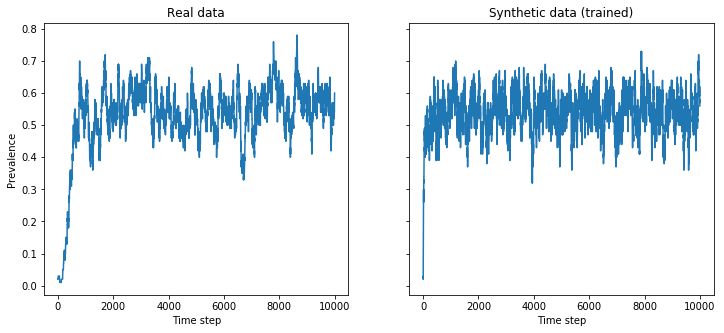

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True,sharey=True)

ax[0].plot(avg_ts)
ax[0].set_title('Real data')
ax[0].set_ylabel('Prevalence')
ax[0].set_xlabel('Time step')

#ax[1].plot(null_ts)
#ax[1].set_title('Synthetic data (untrained)')
#ax[1].set_xlabel('Time step')

ax[1].plot(trained_ts)
ax[1].set_title('Synthetic data (trained)')
ax[1].set_xlabel('Time step')

fig.savefig('fig/png/nodemodel_test_rrgsis_d5_n100_rate0.4.png')
fig.savefig('fig/pdf/nodemodel_test_rrgsis_d5_n100_rate0.4.pdf')
plt.show()